In [1]:
!pip install -q -U "google-generativeai>=0.7.2"

In [43]:
import os
import pandas as pd
import google.generativeai as genai
import pathlib
import random
import json
import pandas as pd
import seaborn as sns

In [4]:
from google.colab import userdata
genai.configure(api_key=userdata.get('GEMINI_KEY'))

In [5]:
tunable_models = [
    m for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods]
tunable_models

[Model(name='models/gemini-1.0-pro-001',
       base_model_id='',
       version='001',
       display_name='Gemini 1.0 Pro 001 (Tuning)',
       description=('The original Gemini 1.0 Pro model version that supports tuning. Gemini 1.0 '
                    'Pro will be discontinued on February 15th, 2025. Move to a newer Gemini '
                    'version.'),
       input_token_limit=30720,
       output_token_limit=2048,
       supported_generation_methods=['generateContent', 'countTokens', 'createTunedModel'],
       temperature=0.9,
       max_temperature=None,
       top_p=1.0,
       top_k=None),
 Model(name='models/gemini-1.5-flash-001-tuning',
       base_model_id='',
       version='001',
       display_name='Gemini 1.5 Flash 001 Tuning',
       description=('Version of Gemini 1.5 Flash that supports tuning, our fast and versatile '
                    'multimodal model for scaling across diverse tasks, released in May of 2024.'),
       input_token_limit=16384,
       outpu

In [7]:
df = pd.read_csv("/content/small_set - Sheet1.csv")

In [8]:
data_path = "/content/small_set - Sheet1.csv"

In [9]:
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [10]:
# Create a json (title/content)
output_json_path = '/content/imdb.json'
json_data = [
    {
        "text_input": row["review"],
        "output": row["sentiment"]
    }
    for _, row in df.iterrows()
]
with open(output_json_path, "w", encoding="utf-8") as f:
    json.dump(json_data, f, indent=4, ensure_ascii=False)

print("Data successfully saved to movies.json")

Data successfully saved to movies.json


In [11]:
with open(output_json_path, "r") as file:
  json_file = file.read()

In [12]:
json_file

'[\n    {\n        "text_input": "One of the other reviewers has mentioned that after watching just 1 Oz episode you\'ll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main a

In [13]:
def load_json_as_list_of_dicts(file_path):
  """
  Loads a JSON file containing a list of dictionaries.

  Args:
    file_path: Path to the JSON file.

  Returns:
    A list of dictionaries loaded from the JSON file.
  """
  with open(file_path, 'r') as f:
    data = json.load(f)

  if isinstance(data, list):
    return data
  else:
    raise ValueError("JSON file does not contain a list of dictionaries.")

In [14]:
data_list = load_json_as_list_of_dicts(output_json_path)
data_list

[{'text_input': "One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show 

In [15]:
csv_file=pathlib.Path("/content/small_set - Sheet1.csv")
train_data = csv_file

In [16]:
train_data

PosixPath('/content/small_set - Sheet1.csv')

In [17]:
base_model = [m for m in tunable_models if 'flash' in m.name][-1]
base_model

Model(name='models/gemini-1.5-flash-001-tuning',
      base_model_id='',
      version='001',
      display_name='Gemini 1.5 Flash 001 Tuning',
      description=('Version of Gemini 1.5 Flash that supports tuning, our fast and versatile '
                   'multimodal model for scaling across diverse tasks, released in May of 2024.'),
      input_token_limit=16384,
      output_token_limit=8192,
      supported_generation_methods=['generateContent', 'countTokens', 'createTunedModel'],
      temperature=1.0,
      max_temperature=2.0,
      top_p=0.95,
      top_k=64)

In [18]:
name = f'generate-num-{random.randint(0,10000)}'
operation = genai.create_tuned_model(
    source_model=base_model.name,
    training_data=data_list,
    id = name,
    epoch_count = 100,
    batch_size=4,
    learning_rate=0.001,
)

In [36]:
name

'generate-num-2861'

In [40]:
genai.update_tuned_model(f'tunedModels/{name}', {"description":"Classifies imdb ratings as positive or negative."});

In [42]:
model = genai.get_tuned_model(f'tunedModels/{name}')
model.description

'Classifies imdb ratings as positive or negative.'

In [19]:
model = genai.get_tuned_model(f'tunedModels/{name}')

model

TunedModel(name='tunedModels/generate-num-2861',
           source_model='models/gemini-1.5-flash-001-tuning',
           base_model='models/gemini-1.5-flash-001-tuning',
           display_name='',
           description='',
           temperature=1.0,
           top_p=0.95,
           top_k=64,
           state=<State.CREATING: 1>,
           create_time=datetime.datetime(2025, 1, 2, 23, 37, 18, 539417, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2025, 1, 2, 23, 37, 18, 539417, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=datetime.datetime(2025, 1, 2, 23, 37, 21, 150263, tzinfo=datetime.timezone.utc),
                                  complete_time=None,
                                  snapshots=[],
                                  hyperparameters=Hyperparameters(epoch_count=100,
                                                                  batch_size=4,
                                                                 

In [20]:
model.state

<State.CREATING: 1>

In [21]:
operation.metadata

tuned_model: "tunedModels/generate-num-2861"
total_steps: 725

In [22]:
import time

for n,status in enumerate(operation.wait_bar()):
  if n%100 == 0:
    print()
  print('.', end='')
  time.sleep(10)

  0%|          | 0/725 [00:00<?, ?it/s]


....................................................................................................
......................................................................

<Axes: xlabel='epoch', ylabel='mean_loss'>

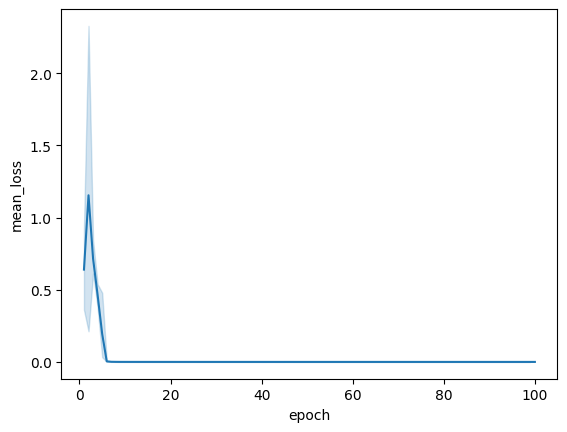

In [45]:
model = operation.result()

snapshots = pd.DataFrame(model.tuning_task.snapshots)

sns.lineplot(data=snapshots, x = 'epoch', y='mean_loss')

In [24]:
model = genai.GenerativeModel(model_name=f'tunedModels/{name}')

In [30]:
review = '''
One of the most significant quotes from the entire film is pronounced halfway through by the protagonist, the mafia middle-man Titta Di Girolamo, a physically non-descript, middle-aged man originally from Salerno in Southern Italy. When we're introduced to him at the start of the film, he's been living a non-life in an elegant but sterile hotel in the Italian-speaking Canton of Switzerland for the last ten years, conducting a business we are only gradually introduced to. While this pivotal yet apparently unremarkable scene takes place employees of the the Swiss bank who normally count Di Girolamo's cash tell him that 10,000 dollars are missing from his usual suitcase full of tightly stacked banknotes. At the news, he quietly but icily threatens his coaxing bank manager of wanting to close down his account. Meanwhile he tells us, the spectators, that when you bluff, you have to bluff right through to the end without fear of being caught out or appearing ridiculous. He says: you can't bluff for a while and then halfway through, tell the truth. Having eventually done this - bluffed only halfway through and told the truth, and having accepted the consequences of life and ultimately, love - is exactly the reason behind the beginning of Titta Di Girolamo's troubles. <br /><br />This initially unsympathetic character, a scowling, taciturn, curt man on the verge of 50, a man who won't even reply in kind to chambermaids and waitresses who say hello and goodbye, becomes at one point someone the spectator cares deeply about. At one point in his non-life, Titta decides to feel concern about appearing "ridiculous". The first half of the film may be described as "slow" by some. It does indeed reveal Di Girolamo's days and nights in that hotel at an oddly disjoined, deliberate pace, revealing seemingly mundane and irrelevant details. However, scenes that may have seemed unnecessary reveal just how essential they are as this masterfully constructed and innovative film unfolds before your eyes. The existence of Titta Di Girolamo - the man with no imagination, identity or life, the unsympathetic character you unexpectedly end up loving and feeling for when you least thought you would - is also conveyed with elegantly edited sequences and very interesting use of music (one theme by the Scottish band Boards of Canada especially stood out). <br /><br />Never was the contrast between the way Hollywood and Italy treat mobsters more at odds than since the release of films such as Le Conseguenze dell'Amore or L'Imbalsamatore. Another interesting element was the way in which the film made use of the protagonist's insomnia. Not unlike The Machinist (and in a far more explicit way, the Al Pacino film Insomnia), Le Conseguenze dell'Amore uses this condition to symbolise a deeper emotional malaise that's been rammed so deep into the obscurity of the unconscious, it's almost impossible to pin-point its cause (if indeed there is one). <br /><br />The young and sympathetic hotel waitress Sofia (played by Olivia Magnani, grand-daughter of the legendary Anna) and the memory of Titta's best friend, a man whom he hasn't seen in 20 years, unexpectedly provide a tiny window onto life that Titta eventually (though tentatively at first) accepts to look through again. Though it's never explicitly spelt out, the spectator KNOWS that to a man like Titta, accepting The Consequences of Love will have unimaginable consequences. A film without a single scene of sex or violence, a film that unfolds in its own time and concedes nothing to the spectator's expectations, Le Conseguenze dell'Amore is a fine representative of that small, quiet, discreet Renaissance that has been taking place in Italian cinema since the decline of Cinecittà during the second half of the 70s. The world is waiting for Italy to produce more Il Postino-like fare, more La Vita è Bella-style films... neglecting to explore fine creations like Le Conseguenze dell'Amore, L'Imbalsamatore and others. Your loss, world.
'''

response = model.generate_content(review)

In [31]:
response.text

'positive'

In [32]:
review = '''
Of all the films I have seen, this one, The Rage, has got to be one of the worst yet. The direction, LOGIC, continuity, changes in plot-script and dialog made me cry out in pain. "How could ANYONE come up with something so crappy"? Gary Busey is know for his "B" movies, but this is a sure "W" movie. (W=waste).<br /><br />Take for example: about two dozen FBI & local law officers surround a trailer house with a jeep wagoneer. Inside the jeep is MA and is "confused" as to why all the cops are about. Within seconds a huge gun battle ensues, MA being killed straight off. The cops blast away at the jeep with gary and company blasting away at them. The cops fall like dominoes and the jeep with Gary drives around in circles and are not hit by one single bullet/pellet. MA is killed and gary seems to not to have noticed-damn that guy is tough. Truly a miracle, not since the six-shooter held 300 bullets has there been such a miracle.
'''

In [33]:
response = model.generate_content(review)
response.text

'negative'

In [34]:
review = '''
I remember seeing this film in the mid 80's thought it a well paced and well acted piece. I now work quite often in Berkeley Square and the had to get a copy of DVD to remind myself how little the area has changed, although my office is newish it just 30 seconds away from "the bank". Even Jack Barclays car dealership is still there selling Bentleys and Rolls Royces.<br /><br />It's look like the DVD is due a Region 2 release soon. The region 1 copy I is very poor quality. Let's hope they've cleaned it up.<br /><br />Only the slightly dodgy escape sequence from the court spoils what would otherwise be a great film but I guess is in line with the caper tag the film goes with.
'''

In [35]:
response = model.generate_content(review)
response.text

'positive'